In [16]:
import numpy as np
import matplotlib.pyplot as plt

def daq_encoder(x: np.ndarray) -> (np.ndarray, np.ndarray):
    """
    DAQ Encoder (Algorithm 8).
    
    Args: x: The input vector of real numbers.
        
    Returns:
        - w: The quantized binary vector.
        - U: The random dither vector used (needed for the decoder).
    """
    d = len(x)
# sample U from a Uniform distribution on [-1, 1]
    U = np.random.uniform(-1, 1, size=d)
    
    w = (U <= x).astype(int) # 0 if U is greater than x, 1 if vice versa
    
    return w, U

def daq_decoder(w: np.ndarray, y: np.ndarray, U: np.ndarray) -> np.ndarray:
    """
 DAQ Decoder (Algorithm 9).
    
    Args:
        w: The received binary vector from the encoder.
        y: The local vector at the decoder.
        U: The public random dither vector (must be the same as the one
           used by the encoder).
           
    Returns:
        The reconstructed vector.
    """

    y_tilde = (U <= y).astype(int) # same as in encoder function
    
    # Apply the reconstruction formula
    output = 2 * (w - y_tilde) + y
    
    return output

def find_scale_index(vec: np.ndarray, M_scales: list) -> np.ndarray:
    """Helper function to find the smallest scale index for each vector component."""
    d = len(vec)
    z = np.zeros(d, dtype=int)
    for i in range(d):
        # Find the first scale j where the component fits
        found = False
        for j in range(len(M_scales)):
            if np.abs(vec[i]) <= M_scales[j]:
                z[i] = j
                found = True
                break
        # If  larger than all scales, use the largest scale
        if not found:
            z[i] = len(M_scales) - 1
    return z

def rdaq_encoder(x: np.ndarray, M_scales: list, R: np.ndarray):
    """
    Implements the RDAQ Encoder (Algorithm 10).
    """
    d = len(x)
    h = len(M_scales)
    
    # 1. Generate h sets of random dither, one for each scale
    U = np.zeros((h, d))
    for j in range(h):
        U[j, :] = np.random.uniform(-M_scales[j], M_scales[j], size=d)
    
    # 2. Rotate the input vector
    x_R = R @ x
    
    # 3. Find the smallest scale that contains each component of x_R
    z = find_scale_index(x_R, M_scales)
    
    # 4. Quantize x_R at all h scales
    # We use broadcasting: U is (h,d), x_R is (d,), so x_R is compared to each row of U
    w = (U <= x_R).astype(int)
    
    return w, z, R, U

def rdaq_decoder(w: np.ndarray, z: np.ndarray, y: np.ndarray, M_scales: list, R: np.ndarray, U: np.ndarray):
    """
    Implements the RDAQ Decoder (Algorithm 11).
    """
    d = len(y)
    h = len(M_scales)
    
    # 2. Rotate the local vector y
    y_R = R @ y
    
    # 3. Determine the final scale z*
    z_y = find_scale_index(y_R, M_scales)
    z_star = np.maximum(z, z_y)
    
    # 4. Construct the effective binary vector w_prime and scaling vector M_z_star
    w_prime = np.zeros(d)
    y_R_tilde = np.zeros(d)
    M_z_star = np.zeros(d)
    
    for i in range(d):
        scale_idx = z_star[i]
        # Pick the correct bit from the received data w
        w_prime[i] = w[scale_idx, i]
        # Quantize y_R at the chosen scale
        y_R_tilde[i] = (U[scale_idx, i] <= y_R[i]).astype(int)
        # Select the corresponding scale magnitude
        M_z_star[i] = M_scales[scale_idx]

    # Calculate the estimate in the rotated space
    x_hat_R = 2 * M_z_star * (w_prime - y_R_tilde) + y_R
    
    # 5. Perform the inverse rotation for the final output
    R_inv = np.linalg.inv(R)
    output = R_inv @ x_hat_R
    
    return output, z_star

# --- Subsampled RDAQ Algorithm Implementations ---

def subsampled_rdaq_encoder(x: np.ndarray, M_scales: list, R: np.ndarray, mu: float):
    """Implements the Subsampled RDAQ Encoder."""
    d = len(x)
    h = len(M_scales)
    
    # 1. Choose a random subset S of coordinates
    subset_size = int(np.ceil(d * mu))
    if subset_size > d: subset_size = d
    S = np.random.choice(d, size=subset_size, replace=False)

    # 2. Perform the full RDAQ encoding steps internally
    U = np.zeros((h, d))
    for j in range(h):
        U[j, :] = np.random.uniform(-M_scales[j], M_scales[j], size=d)
    x_R = R @ x
    z = find_scale_index(x_R, M_scales)
    w = (U <= x_R).astype(int)
    
    # 3. Return only the information for the subset S
    return w[:, S], z[S], S, R, U

def subsampled_rdaq_decoder(w_sub: np.ndarray, z_sub: np.ndarray, S: np.ndarray, 
                            y: np.ndarray, M_scales: list, R: np.ndarray, 
                            U: np.ndarray, mu: float):
    """Implements the Subsampled RDAQ Decoder."""
    d = len(y)
    y_R = R @ y
    z_y = find_scale_index(y_R, M_scales)
    
    # Determine the final scale z*, but only for the subset S
    z_star_sub = np.maximum(z_sub, z_y[S])
    
    # Create a correction vector that will be non-zero only at indices in S
    correction_vec_R = np.zeros(d)
    
    # The main loop now only iterates over the subset S
    for k, i in enumerate(S):  # k is the index for subset arrays, i is for full arrays
        scale_idx = z_star_sub[k]
        w_prime_i = w_sub[scale_idx, k]
        y_R_tilde_i = (U[scale_idx, i] <= y_R[i]).astype(int)
        M_z_star_i = M_scales[scale_idx]
        
        correction_vec_R[i] = 2 * M_z_star_i * (w_prime_i - y_R_tilde_i)

    # Scale the correction vector by 1/μ and add to the rotated side info
    x_hat_R = (1 / mu) * correction_vec_R + y_R
    
    # Inverse rotate for the final estimate
    R_inv = np.linalg.inv(R)
    output = R_inv @ x_hat_R
    
    return output



 4.2 Distance Adaptive Quantizer (DAQ)

Running 1000 simulations for DAQ...
True value of x = 0.6000
Noise Level (Std Dev) = 0.2
Generated side information y = 0.6141 (x + noise)

     SIMULATION RESULTS
Average of all 1000 outputs: 0.5981
Conclusion: The average is very close to the true value of x.


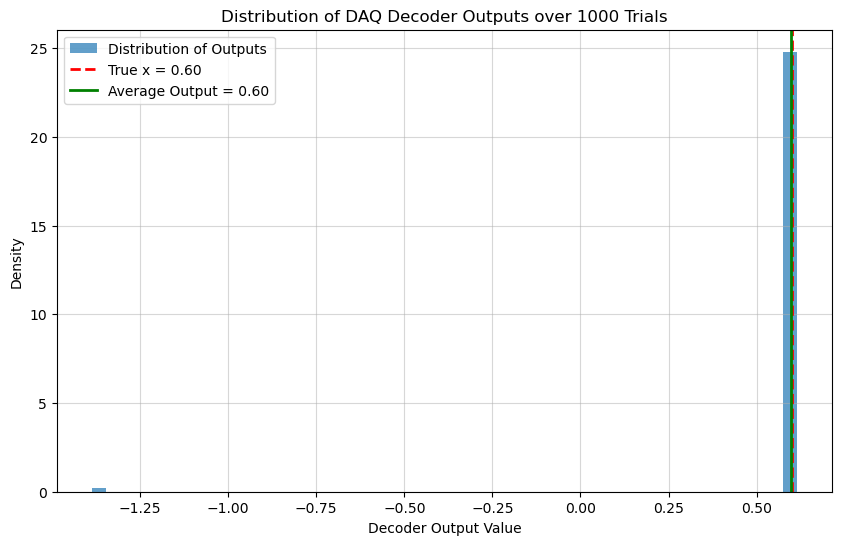

In [31]:
# --- Testing for DAQ

num_trials = 1000
results = []

# 1. Define the true value of x
x_true = np.array([0.6])

# 2. Define the correlation strength via noise level
# A smaller value means y is more correlated (closer) to x.
noise_level = 0.2  # This is the standard deviation of the noise

# 3. Generate the correlated side information y
# y = x + random_gaussian_noise
noise = np.random.normal(loc=0.0, scale=noise_level, size=x_true.shape)
y_side_info = x_true + noise

print(f"Running {num_trials} simulations for DAQ...")
print(f"True value of x = {x_true[0]:.4f}")
print(f"Noise Level (Std Dev) = {noise_level}")
print(f"Generated side information y = {y_side_info[0]:.4f} (x + noise)")



for _ in range(num_trials):
    w, U = daq_encoder(x_true)
    output = daq_decoder(w, y_side_info, U)
    results.append(output[0])


# --- Results ---
results_array = np.array(results)
average_output = np.mean(results_array)

print("\n" + "="*25)
print("     SIMULATION RESULTS")
print("="*25)
print(f"Average of all {num_trials} outputs: {average_output:.4f}")
print(f"Conclusion: The average is very close to the true value of x.")


# --- Visuals ---
plt.figure(figsize=(10, 6))
plt.hist(results_array, bins=50, density=True, alpha=0.7, label='Distribution of Outputs')
plt.axvline(x=x_true[0], color='red', linestyle='--', linewidth=2, label=f'True x = {x_true[0]:.2f}')
plt.axvline(x=average_output, color='green', linestyle='-', linewidth=2, label=f'Average Output = {average_output:.2f}')
plt.title(f'Distribution of DAQ Decoder Outputs over {num_trials} Trials')
plt.xlabel('Decoder Output Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

4.3 Rotated Distance Adaptive Quantizer (RDAQ)
    LENGTH MATTERS

Running 1000 simulations for RDAQ (Example 2)...
True value x = 0.7, Side info y = 3.2

--- Simulation Results ---
Average of all 1000 outputs: 0.7520
This is very close to the true value of x (0.7).


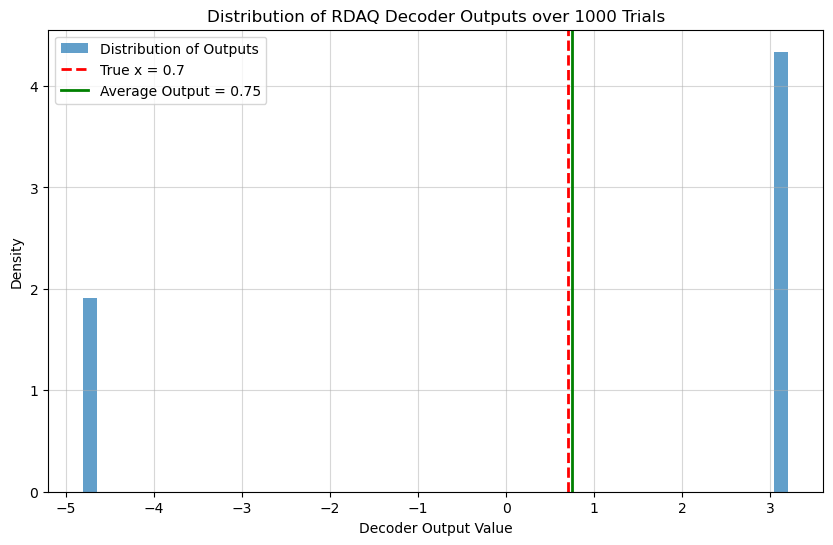

In [35]:
# --- Testing RDAQ
num_trials = 1000
results = []

#  Scales Differ
x_true = np.array([0.7])
y_side_info = np.array([3.2])
M_scales = [1.0, 4.0]
R = np.identity(1)

print(f"Running {num_trials} simulations for RDAQ (Example 2)...")
print(f"True value x = {x_true[0]}, Side info y = {y_side_info[0]}")


for _ in range(num_trials):
    w, z, _, U = rdaq_encoder(x_true, M_scales, R)
    output, _ = rdaq_decoder(w, z, y_side_info, M_scales, R, U)
    results.append(output[0])

# --- Results ---
results_array = np.array(results)
average_output = np.mean(results_array)

print("\n--- Simulation Results ---")
print(f"Average of all {num_trials} outputs: {average_output:.4f}")
print(f"This is very close to the true value of x ({x_true[0]}).")

# --- Visuals ---
plt.figure(figsize=(10, 6))
plt.hist(results_array, bins=50, density=True, alpha=0.7, label='Distribution of Outputs')

# Add a vertical line for the true value of x
plt.axvline(x=x_true[0], color='red', linestyle='--', linewidth=2, label=f'True x = {x_true[0]}')

# Add a vertical line for the average of the outputs
plt.axvline(x=average_output, color='green', linestyle='-', linewidth=2, label=f'Average Output = {average_output:.2f}')

plt.title(f'Distribution of RDAQ Decoder Outputs over {num_trials} Trials')
plt.xlabel('Decoder Output Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

4.4 Subsampled RDAQ: A universal Wyner-Ziv quantizer for unit Euclidean ball

Starting Subsampled RDAQ simulation for different mu values...
------------------------------------------------------------
Running simulation for mu = 0.2 (2 out of 10 coordinates)...
  -> MSE over 1000 trials: 181.7745

Running simulation for mu = 0.5 (5 out of 10 coordinates)...
  -> MSE over 1000 trials: 62.1183

Running simulation for mu = 0.9 (9 out of 10 coordinates)...
  -> MSE over 1000 trials: 33.6239

  Final MSE Results Summary
μ = 0.2 (using 2/10 coords) -> MSE = 181.7745
μ = 0.5 (using 5/10 coords) -> MSE = 62.1183
μ = 0.9 (using 9/10 coords) -> MSE = 33.6239


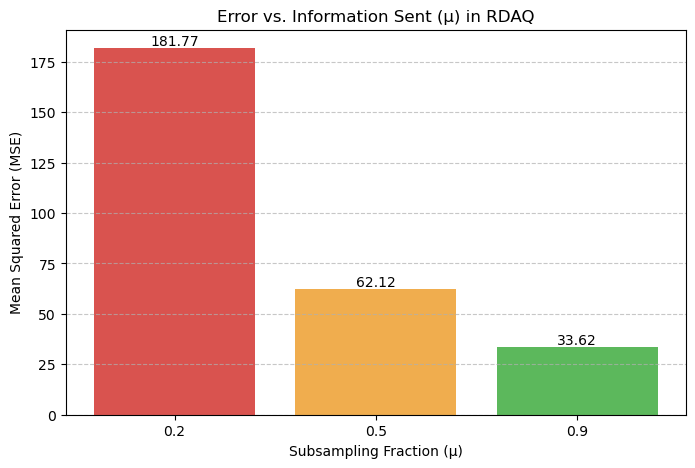

In [39]:
#  SUBSAMPLED RDAQ
num_trials = 1000
mu_values_to_test = [0.2, 0.5, 0.9]
mse_results = {}

# Common parameters for a fair comparison
d = 10
M = [1.0, 4.0]
np.random.seed(0)
R = np.linalg.svd(np.random.randn(d, d))[0]
x_true = np.random.randn(d)
y_side_info = x_true + np.random.normal(loc=0.0, scale=0.5, size=d)

print("Starting Subsampled RDAQ simulation for different mu values...")
print("-" * 60)

# --- Outer loop to test each value of mu ---
for mu in mu_values_to_test:
    results_list = []
    num_coords = int(np.ceil(d * mu))
    print(f"Running simulation for mu = {mu} ({num_coords} out of {d} coordinates)...")

    # --- Inner simulation loop for the current mu ---
    for _ in range(num_trials):
        w_sub, z_sub, S, _, U = subsampled_rdaq_encoder(x_true, M, R, mu)
        output = subsampled_rdaq_decoder(w_sub, z_sub, S, y_side_info, M, R, U, mu)
        results_list.append(output)

    # --- Analysis for the current mu ---
    results_array = np.array(results_list)
    errors_squared = np.sum((results_array - x_true)**2, axis=1)
    mse = np.mean(errors_squared)
    
    mse_results[mu] = mse # Store result for final summary
    print(f"  -> MSE over {num_trials} trials: {mse:.4f}\n")

# --- Summary ---
print("="*35)
print("  Final MSE Results Summary")
print("="*35)
for mu, mse in mse_results.items():
    print(f"μ = {mu:<3} (using {int(d*mu)}/10 coords) -> MSE = {mse:.4f}")

# --- Visuals of Trade-off ---
mu_labels = [str(m) for m in mse_results.keys()]
mse_values = list(mse_results.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(mu_labels, mse_values, color=['#d9534f', '#f0ad4e', '#5cb85c'])
plt.xlabel("Subsampling Fraction (μ)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Error vs. Information Sent (μ) in RDAQ")
plt.bar_label(bars, fmt='{:.2f}')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()